In [1]:
# Method #2 HAR-X Model
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Method #3 Regularisation Model
from sklearn.linear_model import ElasticNet

from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error
from set_params import func_train_test_split, count_train_test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
import warnings

def calculate_iqr(values):
    # Calculate Q1
    Q1 = np.percentile(values, 25)
    # Calculate Q3
    Q3 = np.percentile(values, 75)
    # Calculate IQR
    IQR = Q3 - Q1
    return IQR

def detect_outliers_iqr(values):
    # Calculate the IQR of the values
    IQR = calculate_iqr(values)
    # Calculate Q1 and Q3
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    # Define the lower and upper bound for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return a boolean array: True if the value is an outlier, False otherwise
    return lower_bound, upper_bound

def vis_line_plot_results(y_pred, y_test, model = 'HAR', name = 'BARCLAYS', r = 1, dataset = 'm1'):

    plt.figure(figsize=(10,4))
    true, = plt.plot(y_test)
    preds, = plt.plot(y_pred)
    plt.title(f'{model}-{dataset}-{name}', fontsize=15)
    plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=9)
    plt.xticks(rotation=45)
    plt.savefig(f'../outputs/{model}-{dataset}/{str(r+1).zfill(3)}-{model}-{name}.png')
    plt.close()

# display(HTML("<style>.container { width:80% !important; }</style>"))
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [2]:
base_FTSE_df = pd.read_csv('../data/1.3-FTSE_Monthly_ESG_Volatility_Final.csv')
base_FTSE_df = base_FTSE_df.rename(columns={'Date_x':'date_key'})

In [3]:
train_df, valid_df, test_df = func_train_test_split(validation = False, threshold = 24)

In [4]:
count_rows_df = count_train_test(train_df, test_df)

In [5]:
coverage_df = pd.read_csv('../data/coverage_dataframe.csv')
coverage_df.PermID = coverage_df.PermID.astype(int)
coverage_df = coverage_df[['PermID', 'Name']]
coverage_df = coverage_df.rename(columns={'PermID':'Asset'})

In [6]:
train_df = pd.merge(train_df, coverage_df, how = 'left', on = 'Asset')
train_df.index = train_df.month_key

In [7]:
cols = ['Asset',
    'buzz','ESG','ESGCombined','ESGControversies','EnvironmentalPillar','GovernancePillar','SocialPillar'
                ,'CSRStrategy','Community','Emissions','EnvironmentalInnovation','HumanRights','Management','ProductResponsibility'
                ,'ResourceUse','Shareholders','Workforce', 'vol_series_daily','vol_series_weekly','vol_series_monthly', 'V^YZ']

In [8]:
train_df = train_df[cols]
test_df = test_df[cols]

In [9]:
train_df = train_df[train_df.Asset == 4295885039].drop(['Asset'], axis=1)
test_df = test_df[test_df.Asset == 4295885039].drop(['Asset'], axis=1)

In [10]:
merge_df = pd.concat([train_df, test_df])

In [11]:
test_size = test_df.shape[0]

In [12]:
# forecast monthly births with random forest
import pandas as pd
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, target = 'y',dropnan=True):
    cols = list()
    colname = data.columns
    dropcols = [col for col in colname if col not in target]
    print('dropping columns:', dropcols)
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        temp_df = data.shift(i)
        colname = temp_df.columns + f'_s{i}'
        temp_df.columns = colname
        cols.append(temp_df)
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
        
    # put it all together
    agg = concat(cols, axis=1)
    agg = pd.DataFrame(agg)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg.drop(dropcols, axis=1).values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.4f, predicted=%.4f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [13]:
merge_df.shape

(203, 21)

In [14]:
merge_df = merge_df.dropna()

In [15]:
# series = read_csv('../data/total-female-births.csv', header=0, index_col=0)
# series.loc[:,'Birth^2'] = series['Births'] ** 2
# series = series[['Birth^2', 'Births']]
data = series_to_supervised(merge_df, n_in=6, target= 'V^YZ')

dropping columns: ['buzz', 'ESG', 'ESGCombined', 'ESGControversies', 'EnvironmentalPillar', 'GovernancePillar', 'SocialPillar', 'CSRStrategy', 'Community', 'Emissions', 'EnvironmentalInnovation', 'HumanRights', 'Management', 'ProductResponsibility', 'ResourceUse', 'Shareholders', 'Workforce', 'vol_series_daily', 'vol_series_weekly', 'vol_series_monthly']


In [16]:
data.shape

(185, 127)

In [17]:
pd.DataFrame(data).tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126
180,219484.0,86.0,63.0,39.0,94.0,83.0,82.0,81.0,75.0,94.0,96.0,84.0,86.0,81.0,91.0,75.0,86.0,0.022880,0.021407,0.018898,0.024684,208708.5,86.0,63.0,39.0,93.0,82.0,82.0,83.0,80.0,94.0,95.0,81.0,84.0,84.0,91.0,76.0,85.0,0.024684,0.022209,0.019205,0.020149,211702.0,84.0,59.0,34.0,94.0,76.0,83.0,73.0,...,92.0,3.0,92.0,0.020678,0.021837,0.019462,0.020571,201935.0,77.0,56.0,35.0,93.0,49.0,88.0,26.0,83.0,93.0,96.0,90.0,68.0,83.0,91.0,4.0,91.0,0.020571,0.020466,0.019832,0.024584,197664.0,76.0,55.0,34.0,93.0,47.0,87.0,2.0,82.0,93.0,96.0,90.0,68.0,85.0,91.0,6.0,88.0,0.024584,0.021945,0.020329,0.017762,0.018419
181,208708.5,86.0,63.0,39.0,93.0,82.0,82.0,83.0,80.0,94.0,95.0,81.0,84.0,84.0,91.0,76.0,85.0,0.024684,0.022209,0.019205,0.020149,211702.0,84.0,59.0,34.0,94.0,76.0,83.0,73.0,81.0,95.0,96.0,81.0,78.0,84.0,91.0,72.0,86.0,0.020149,0.022571,0.019242,0.020678,211701.0,81.0,58.0,36.0,94.0,62.0,86.0,73.0,...,91.0,4.0,91.0,0.020571,0.020466,0.019832,0.024584,197664.0,76.0,55.0,34.0,93.0,47.0,87.0,2.0,82.0,93.0,96.0,90.0,68.0,85.0,91.0,6.0,88.0,0.024584,0.021945,0.020329,0.017762,197169.5,74.0,54.0,34.0,93.0,43.0,87.0,2.0,83.0,93.0,95.0,92.0,62.0,83.0,91.0,7.0,85.0,0.017762,0.020973,0.020430,0.018419,0.020742
182,211702.0,84.0,59.0,34.0,94.0,76.0,83.0,73.0,81.0,95.0,96.0,81.0,78.0,84.0,91.0,72.0,86.0,0.020149,0.022571,0.019242,0.020678,211701.0,81.0,58.0,36.0,94.0,62.0,86.0,73.0,81.0,95.0,96.0,85.0,78.0,83.0,92.0,3.0,92.0,0.020678,0.021837,0.019462,0.020571,201935.0,77.0,56.0,35.0,93.0,49.0,88.0,26.0,...,91.0,6.0,88.0,0.024584,0.021945,0.020329,0.017762,197169.5,74.0,54.0,34.0,93.0,43.0,87.0,2.0,83.0,93.0,95.0,92.0,62.0,83.0,91.0,7.0,85.0,0.017762,0.020973,0.020430,0.018419,198941.5,74.0,55.0,35.0,94.0,41.0,87.0,4.0,83.0,93.0,95.0,92.0,59.0,78.0,93.0,9.0,87.0,0.018419,0.020255,0.020679,0.020742,0.019422
183,211701.0,81.0,58.0,36.0,94.0,62.0,86.0,73.0,81.0,95.0,96.0,85.0,78.0,83.0,92.0,3.0,92.0,0.020678,0.021837,0.019462,0.020571,201935.0,77.0,56.0,35.0,93.0,49.0,88.0,26.0,83.0,93.0,96.0,90.0,68.0,83.0,91.0,4.0,91.0,0.020571,0.020466,0.019832,0.024584,197664.0,76.0,55.0,34.0,93.0,47.0,87.0,2.0,...,91.0,7.0,85.0,0.017762,0.020973,0.020430,0.018419,198941.5,74.0,55.0,35.0,94.0,41.0,87.0,4.0,83.0,93.0,95.0,92.0,59.0,78.0,93.0,9.0,87.0,0.018419,0.020255,0.020679,0.020742,207401.0,86.0,62.0,38.0,94.0,78.0,87.0,2.0,85.0,95.0,95.0,90.0,91.0,79.0,94.0,82.0,87.0,0.020742,0.018974,0.021034,0.019422,0.016998
184,201935.0,77.0,56.0,35.0,93.0,49.0,88.0,26.0,83.0,93.0,96.0,90.0,68.0,83.0,91.0,4.0,91.0,0.020571,0.020466,0.019832,0.024584,197664.0,76.0,55.0,34.0,93.0,47.0,87.0,2.0,82.0,93.0,96.0,90.0,68.0,85.0,91.0,6.0,88.0,0.024584,0.021945,0.020329,0.017762,197169.5,74.0,54.0,34.0,93.0,43.0,87.0,2.0,...,93.0,9.0,87.0,0.018419,0.020255,0.020679,0.020742,207401.0,86.0,62.0,38.0,94.0,78.0,87.0,2.0,85.0,95.0,95.0,90.0,91.0,79.0,94.0,82.0,87.0,0.020742,0.018974,0.021034,0.019422,207072.0,87.0,61.0,36.0,94.0,79.0,87.0,20.0,85.0,95.0,96.0,91.0,89.0,81.0,93.0,86.0,88.0,0.019422,0.019527,0.020936,0.016998,0.014715


>expected=0.0229, predicted=0.0209
>expected=0.0247, predicted=0.0231
>expected=0.0201, predicted=0.0232
>expected=0.0207, predicted=0.0206
>expected=0.0206, predicted=0.0207
>expected=0.0246, predicted=0.0212
>expected=0.0178, predicted=0.0237
>expected=0.0184, predicted=0.0162
>expected=0.0207, predicted=0.0180
>expected=0.0194, predicted=0.0215
>expected=0.0170, predicted=0.0206
>expected=0.0147, predicted=0.0175
MAE: 0.002


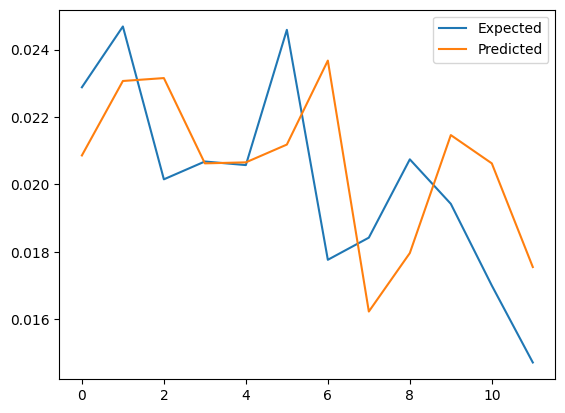

In [18]:
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

>expected=0.0170, predicted=0.0206
>expected=0.0147, predicted=0.0176
MAE: 0.003


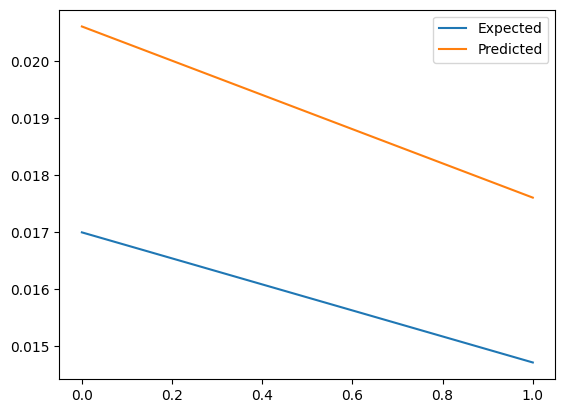

CPU times: user 10.6 s, sys: 124 ms, total: 10.7 s
Wall time: 10.6 s


In [21]:
%%time
mae, y, yhat = walk_forward_validation(data, 2)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()